# Miniproject 1: Tic Tac Toe
This notebook contains the code for Miniproject 1.

In [2]:
# Imports
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from utils import play, save_stats
from plotting import plot_average_rewards, plot_heatmaps, plot_m_values
from qlearner import QPlayer
from deepqlearner import DeepQPlayer, DeepQNetwork, ReplayMemory
from tic_env import OptimalPlayer

## Q-Learning

#### Question 1

In [8]:
epsilons = [0.01, 0.1, 0.2, 0.5, 0.75]

In [ ]:
eps_q_players = []

for eps in epsilons:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=eps)
    play(suboptimal_player, q_player, episodes=20000)
    eps_q_players.append(q_player)

save_stats(players=eps_q_players, path='answers/Q1.npy')

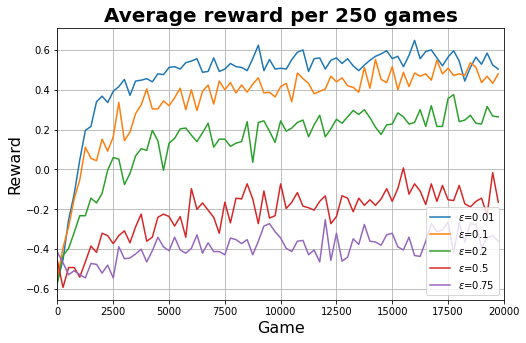

In [9]:
labels = [f'$\epsilon$={eps}' for eps in epsilons]
plot_average_rewards('answers/Q1.npy', labels=labels, save_path='artifacts/fig_Q1.pdf')

#### Question 2

In [10]:
n_stars = [1, 100, 1000, 10000, 40000]

In [ ]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_star_players = []


for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=get_epsilon)
    play(suboptimal_player, q_player, episodes=20000)
    n_star_players.append(q_player)
    
save_stats(players=n_star_players, path='answers/Q2.npy')

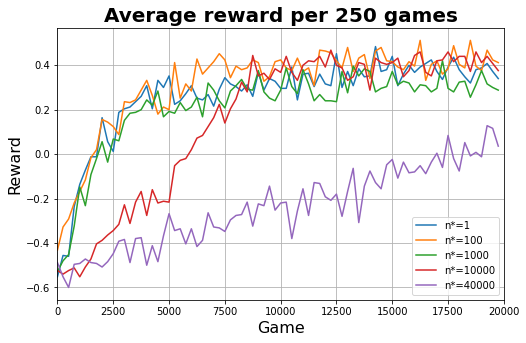

In [11]:
labels = [f'n*={n_star}' for n_star in n_stars]
plot_average_rewards(stats_path='answers/Q2.npy', labels=labels, save_path='artifacts/fig_Q2.pdf')

#### Question 3

In [12]:
n_stars = [1, 100, 1000, 10000, 40000]

In [ ]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_star_players = []

for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=get_epsilon, test_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    n_star_players.append(q_player)
    
save_stats(players=n_star_players, path='answers/Q3.npy')

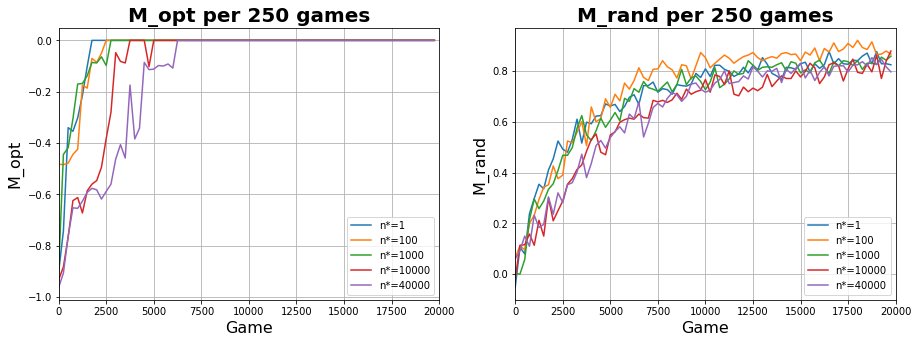

In [13]:
labels = [f"n*={n_star}" for n_star in n_stars]
plot_m_values(stats_path='answers/Q3.npy', labels=labels, save_path='artifacts/fig_Q3.pdf')

#### Question 4

In [15]:
opt_epsilons = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 1]

In [ ]:
N_STAR = 100
EPS_MIN = 0.1
EPS_MAX = 0.8
q_epsilon = lambda n: max(EPS_MIN, EPS_MAX * (1 - n / N_STAR))

eps_players = []

for opt_eps in opt_epsilons:
    other_player = OptimalPlayer(epsilon=opt_eps)
    q_player = QPlayer(epsilon=q_epsilon, test_every=250)
    play(other_player, q_player, episodes=20000)
    eps_players.append(q_player)
    
save_stats(players=eps_players, path='answers/Q4.npy')

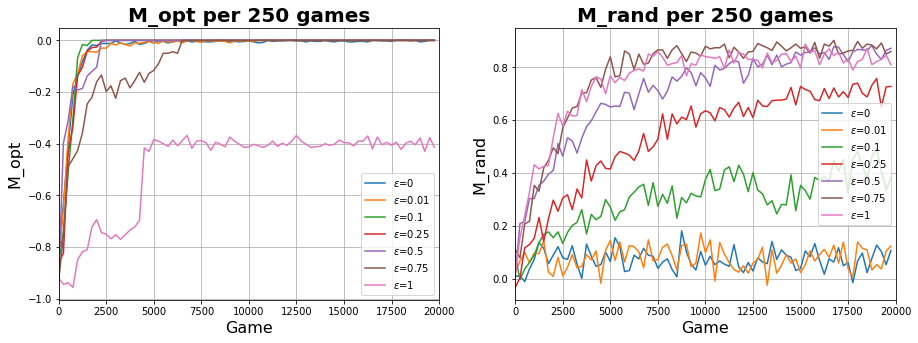

In [16]:
labels = [f'$\epsilon$={eps}' for eps in opt_epsilons]
plot_m_values(stats_path='answers/Q4.npy', labels=labels, save_path='artifacts/fig_Q4.pdf')

#### Question 7

In [17]:
epsilons = [0.01, 0.1, 0.2, 0.5]

In [ ]:
self_q_players = []

for eps in epsilons:
    qvalues = defaultdict(int)
    q_player1 = QPlayer(epsilon=eps, qvalues=qvalues, test_every=250)
    q_player2 = QPlayer(epsilon=eps, qvalues=qvalues, test_every=250)
    play(q_player1, q_player2, episodes=20000)
    self_q_players.append(q_player1)

save_stats(players=self_q_players, path='answers/Q7.npy')

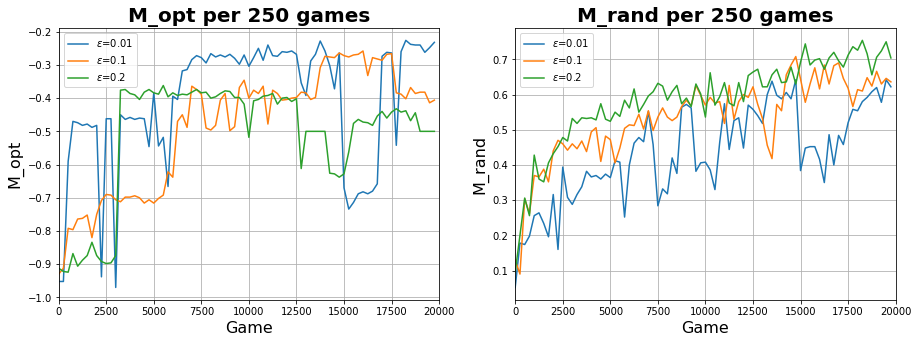

In [18]:
labels = [f'$\epsilon$={eps}' for eps in epsilons]
plot_m_values(stats_path='answers/Q7.npy', labels=labels, save_path='artifacts/fig_Q7.pdf')

#### Question 8

In [19]:
n_stars = [1, 100, 1000, 10000, 40000]

In [ ]:
EPS_MIN = 0.1
EPS_MAX = 0.8
self_n_star_players = []

for n_star in n_stars:
    get_epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    qvalues = defaultdict(int)
    q_player1 = QPlayer(epsilon=get_epsilon, qvalues=qvalues, test_every=250)
    q_player2 = QPlayer(epsilon=get_epsilon, qvalues=qvalues, test_every=250)
    play(q_player1, q_player2, episodes=20000)
    self_n_star_players.append(q_player1)
    
save_stats(players=self_n_star_players, path='answers/Q8.npy')

qvalues = [player.qvalues for player in self_n_star_players]
with open('answers/Q10.npy', 'wb') as npy:
    np.save(npy, qvalues)

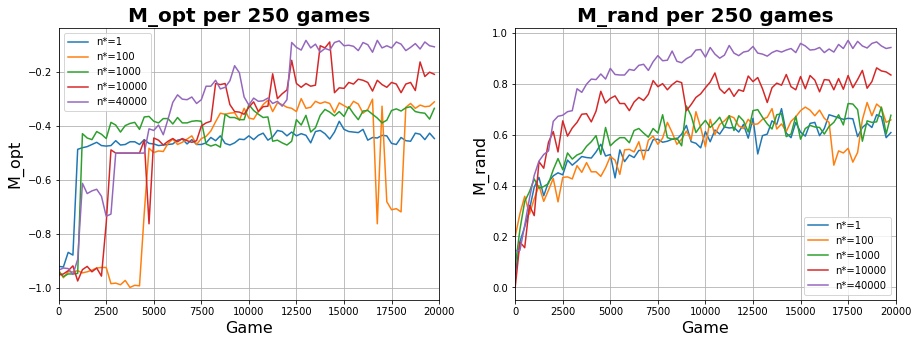

In [20]:
labels = [f'n*={n_star}' for n_star in n_stars]
plot_m_values(stats_path='answers/Q8.npy', labels=labels, save_path='artifacts/fig_Q8.pdf')

#### Question 10

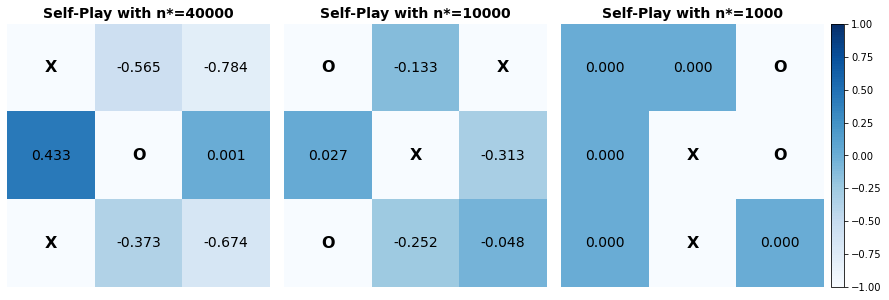

In [21]:
state1 = np.array([
    [1.0, 0.0, 0.0],
    [0.0, -1.0, 0.0],
    [1.0, 0.0, 0.0],
])

state2 = np.array([
    [-1.0, 0.0, 1.0],
    [0.0, 1.0, 0.0],
    [-1.0, 0.0, 0.0],
])

state3 = np.array([
    [0.0, 0.0, -1.0],
    [0.0, 1.0, -1.0],
    [0.0, 1.0, 0.0],
])

with open('answers/Q10.npy', 'rb') as npy:
    qvalues = np.load(npy, allow_pickle=True)

states_list = [state1, state2, state3]
qvalues_list = [qvalues[4], qvalues[3], qvalues[2]]
titles=[f'Self-Play with n*={n_star}' for n_star in [40000, 10000, 1000]]
cmap = plt.cm.get_cmap('Blues', 100)

plot_heatmaps(states_list, qvalues_list, titles=titles, cmap=cmap, save_path='artifacts/fig_Q10.pdf')

## Deep Q-Learning

#### Question 11

In [ ]:
epsilons = [0.001, 0.01, 0.1, 0.2]

for eps in epsilons:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = DeepQPlayer(epsilon=eps)
    play(suboptimal_player, q_player, episodes=20000)

#### Question 12

In [ ]:
epsilons = [0.001, 0.01, 0.1, 0.2]

for eps in epsilons:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = DeepQPlayer(epsilon=eps, batch_size=1, memory_capacity=1)
    play(suboptimal_player, q_player, episodes=20000)

#### Question 13

In [ ]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 50, 100, 500, 1000, 5000, 10000, 20000, 40000]

for n_star in n_stars:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = DeepQPlayer(epsilon=lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star)))
    play(suboptimal_player, q_player, episodes=20000)

#### Question 14

In [ ]:
EPS_MIN = 0.1
EPS_MAX = 0.8
N_STAR = 100
epsilons = [0, 0.01, 0.1, 0.5, 1]

for eps in epsilons:
    other_player = OptimalPlayer(epsilon=eps)
    q_player = DeepQPlayer(epsilon=lambda n: max(EPS_MIN, EPS_MAX * (1 - n / N_STAR)))
    play(other_player, q_player, episodes=20000)

#### Question 16

In [ ]:
epsilons = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5]

for eps in epsilons:
    memory = ReplayMemory()
    policy_net = DeepQNetwork()
    target_net = DeepQNetwork()
    q_player1 = DeepQPlayer(epsilon=eps, policy_net=policy_net, target_net=target_net, memory=memory)
    q_player2 = DeepQPlayer(epsilon=eps, policy_net=policy_net, target_net=target_net, memory=memory, log=False, do_optimize=False)
    play(q_player1, q_player2, episodes=20000)

#### Question 17

In [ ]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 50, 100, 500, 1000, 5000, 10000, 20000, 40000]

for n_star in n_stars:
    memory = ReplayMemory()
    policy_net = DeepQNetwork()
    target_net = DeepQNetwork()
    epsilon = lambda n, n_star=n_star: max(EPS_MIN, EPS_MAX * (1 - n / n_star))
    q_player1 = DeepQPlayer(epsilon=epsilon, policy_net=policy_net, target_net=target_net, memory=memory)
    q_player2 = DeepQPlayer(epsilon=epsilon, policy_net=policy_net, target_net=target_net, memory=memory, log=False, do_optimize=False)
    play(q_player1, q_player2, episodes=20000)

    # Save pretrained model for Question 19
    q_player1.save_pretrained(f"artifacts/q_player_nstar{n_star}")

#### Question 18

#### Question 19

In [5]:
import numpy as np

# # We are looking at 2 grids, one normal grid and
# # a tricky one where the optimal move depends on whether the player is X or O
x_grid = np.array([
    [1.0, 0.0, 0.0],
    [0.0, -1.0, 0.0],
    [1.0, 0.0, 0.0],
])

tricky_grid = np.array([
    [0.0, 0.0, -1.0],
    [0.0, 1.0, -1.0],
    [0.0, 1.0, 0.0],
])

grids = [x_grid, tricky_grid, tricky_grid]

titles=["Player O's turn", "Player X's turn", "Player O's turn"]
cmap = plt.cm.get_cmap('Blues', 100)

In [ ]:
import torch
from qlearner import QStateAction

def get_qvalues(q_player, grid):
    qvalues = {}
    with torch.no_grad():
        predictions = q_player.policy_net(q_player.grid_to_state(grid).unsqueeze(0)).squeeze().numpy()
        for action in range(9):
            qvalues[QStateAction(grid, (action//3, action%3))] = predictions[action]
    return qvalues

q_player = DeepQPlayer.from_pretrained("artifacts/q_player_nstar1000")

qvalues_list = []

# For this grid, we set the player to O (which is the next player in this situation)
q_player.set_player('O')
qvalues_list.append(get_qvalues(q_player, x_grid))

# For the tricky grid, we first set it to X which is the only next player
# in this project because X always goes first
q_player.set_player('X')
qvalues_list.append(get_qvalues(q_player, tricky_grid))

# Next, we set it to O which can also be a next player for this grid
# but in this project this situation is never encountered
# however results show that our agent has in fact learned both
q_player.set_player('O')
qvalues_list.append(get_qvalues(q_player, tricky_grid))

with open('answers/Q19.npy', 'wb') as npy:
    np.save(npy, qvalues_list)

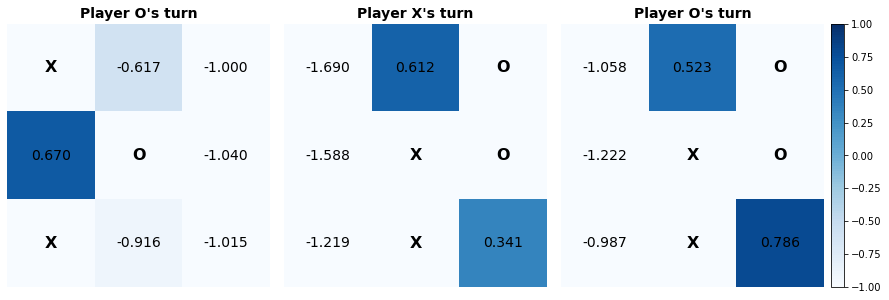

In [6]:
with open('answers/Q19.npy', 'rb') as npy:
    qvalues = np.load(npy, allow_pickle=True)

plot_heatmaps(grids, qvalues, titles=titles, cmap=cmap)